# Resampling strategies
Resampling strategies address class imbalance at the data level, by resampling the dataset to reduce the imbalance ratio. The resampling of an imbalanced dataset occurs before the training of the prediction model and can be seen as a data preprocessing step. Numerous methods have been proposed for resampling imbalanced datasets, which can be categorized into three main strategies: *oversampling*, *undersampling*, and *hybrid* strategies {cite}`fernandez2018learning,JMLR:v18:16-365,chawla2009data`. 

Oversampling consists in artificially increasing the proportion of samples from the minority class. The most naive approach is *random oversampling* (ROS), in which samples from the minority class are randomly duplicated {cite}`fernandez2018learning`. More sophisticated approaches consist in generating synthetic data by interpolating samples from the minority class. Two standard methods based on interpolation are *SMOTE* (Synthetic Minority Oversampling Technique) {cite}`chawla2002smote` and *ADASYN* (Adaptive Synthetic Sampling) {cite}`he2008adasyn`. 

Undersampling, on the contrary, consists in reducing the imbalance ratio by removing samples from the majority class. Samples may be simply randomly removed, as in *random undersampling* (RUS) {cite}`fernandez2018learning`. RUS is a fast and easy way to balance a dataset and is therefore widely used. A significant drawback of the method is that samples that are useful for the learning process may be discarded {cite}`ali2019review`. More advanced strategies aim at removing samples from overlapping regions (such as NearMiss {cite}`mani2003knn`, Tomek Links {cite}`tomek1976two` or Edited Nearest-Neighbors (ENN) {cite}`wilson1972asymptotic`), or by replacing subsets of samples by their centroids {cite}`yen2009cluster`.

The ability of oversampling or undersampling techniques to improve classification performances largely depends on the characteristics of a dataset. As summarized in {cite}`haixiang2017learning`, oversampling techniques tend to be particularly effective when the number of samples from the minority class is very low. Undersampling techniques, on the other hand, are well-suited for large datasets. In particular, they allow to speed up the training times by reducing the dataset size. 

Oversampling and undersampling techniques can also be combined, resulting in *hybrid* resampling techniques. Hybridization of undersampling and oversampling has been shown to almost always increase the classification performances (Chapter 5, Section 6 in {cite}`fernandez2018learning`). Popular combinations involve SMOTE, together with nearest neighbors based undersampling techniques such as Tomek Links {cite}`tomek1976two,batista2004study` or Edited Nearest-Neighbors (ENN) {cite}`wilson1972asymptotic,batista2003balancing`.

This section explores the use of some popular resampling techniques and discusses their benefits and limitations. The proposed implementation relies on the `imblearn` Python library, which is the most complete and up-to-date Python library for imbalanced learning. The library provides a wide range of resampling techniques that can be easily integrated with the `sklearn` library {cite}`Imblearn`.


In [52]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
%run shared_functions.py
#%run ../Chapter_References/shared_functions.ipynb

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed
        

## Illustrative example

For illustrative purposes, we reuse the same simple classification task as in the [cost-sensitive learning section](Imbalanced_Learning_Illustrative_Example). 

In [2]:
X, y = sklearn.datasets.make_classification(n_samples=5000, n_features=2, n_informative=2,
                                            n_redundant=0, n_repeated=0, n_classes=2,
                                            n_clusters_per_class=1,
                                            weights=[0.95, 0.05],
                                            class_sep=0.5, random_state=0)

dataset_df = pd.DataFrame({'X1':X[:,0],'X2':X[:,1], 'Y':y})


In [3]:
%%capture
fig_distribution, ax = plt.subplots(1, 1, figsize=(5,5))

groups = dataset_df.groupby('Y')
for name, group in groups:
    ax.scatter(group.X1, group.X2, edgecolors='k', label=name,alpha=1,marker='o')
    
ax.legend(loc='upper left', 
          bbox_to_anchor=(1.05, 1),
          title="Class")

The dataset contains 5000 samples with two classes, labeled 0 and 1. 95% of the samples are associated to the class 0, and 5% of the samples to the class 1.

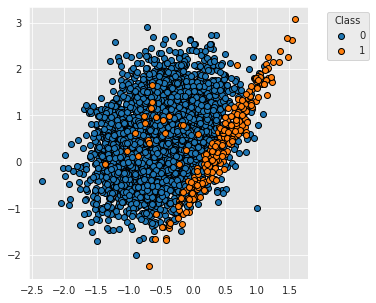

In [4]:
fig_distribution

Following the same methodology as in the [cost-sensitive learning section](Imbalanced_Learning_Illustrative_Example), the performances of a baseline classifier without resampling is obtained with the `kfold_cv_with_classifier` function. A decision tree of depth five and a 5-fold stratified cross-validation gives us the following baseline classification performances. 

In [5]:
%%capture
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=0)

(results_df_dt_baseline, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                     X, y, 
                                                                                     n_splits=5,
                                                                                     strategy_name="Decision tree - Baseline")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)


In [6]:
results_df_dt_baseline

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.004+/-0.001,0.001+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046


The decision boundary of the first classifier of the cross-validation is reported below. Due to class imbalance, the classifier tends to return equal probabilities for the two classes in the overlapping region. 

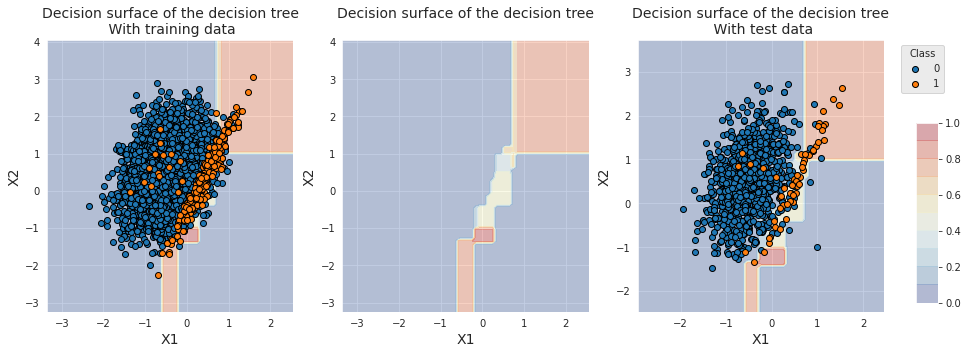

In [7]:
fig_decision_boundary

### Oversampling

Oversampling techniques aim at rebalancing the dataset by creating new samples for the minority class. The two most widely-used methods are *random oversampling* and *SMOTE* {cite}`fernandez2018learning,haixiang2017learning,chawla2002smote`. The next two subsections show how these methods can be implemented, and illustrate their ability to move the decision boundaries towards the minority class. 

#### Random oversampling

Let us first briefly cover how the `imblearn` library allows to resample datasets. A more complete introduction can be found on the library's website, at https://imbalanced-learn.org/dev/introduction.html.

The `imblearn` library provides objects called *samplers*, which take as input a dataset and a set of parameters that are specific to the sampler, and return a resampled dataset. 

For example, the `imblearn` sampler for random oversampling is called [`RandomOverSampler`](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.RandomOverSampler.html). Its main parameter is the `sampling_strategy`, which determines the desired imbalance ratio after random oversampling.

Let us for example create a sampler for random oversampling, where the resampled dataset should have an imbalance ratio of 1 (that is, where samples from the minority class are duplicated until their number equals the number of samples in the majority class).

In [8]:
# random_state is set to 0 for reproducibility
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy=1, random_state=0)

Let us apply this sampler on the `train_df` DataFrame, which is the set of training data in the first fold of the cross-validation performed above. The DataFrame contains 3784 samples of class 0 and 216 samples of class 1. 

In [9]:
train_df['Y'].value_counts()

0    3784
1     216
Name: Y, dtype: int64

The resampling of the dataset is performed by calling the `fit` method of the sampler object. Let `train_df_ROS` be the resampled DataFrame.

In [10]:
X_resampled, Y_resampled = ROS.fit_resample(train_df[['X1','X2']], train_df['Y'])
train_df_ROS = pd.DataFrame({'X1':X_resampled['X1'],'X2':X_resampled['X2'], 'Y':Y_resampled})

The resampled DataFrame now contains as many samples of class 1 as of class 0.

In [11]:
train_df_ROS['Y'].value_counts()

0    3784
1    3784
Name: Y, dtype: int64

Samplers can be combined with `sklearn` estimators using pipelines. The addition of a sampling step in the cross-validation procedure is therefore simple and consists in creating a pipeline made of a sampler, and an estimator. 

The implementation is provided below, in the `kfold_cv_with_sampler_and_classifier` function.

In [12]:
def kfold_cv_with_sampler_and_classifier(classifier,
                                         sampler_list,
                                         X,
                                         y,
                                         n_splits=5,
                                         strategy_name="Baseline classifier"):
    
    # Create a pipeline with the list of samplers, and the estimator
    estimators = sampler_list.copy()
    estimators.extend([('clf', classifier)])
    
    pipe = imblearn.pipeline.Pipeline(estimators)
    
    cv = sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    
    cv_results_ = sklearn.model_selection.cross_validate(pipe,X,y,cv=cv,
                                                         scoring=['roc_auc',
                                                                  'average_precision',
                                                                  'balanced_accuracy'],
                                                         return_estimator=True)
    
    results = round(pd.DataFrame(cv_results_),3)
    results_mean = list(results.mean().values)
    results_std = list(results.std().values)
    results_df = pd.DataFrame([[str(round(results_mean[i],3))+'+/-'+
                                str(round(results_std[i],3)) for i in range(len(results))]],
                              columns=['Fit time (s)','Score time (s)',
                                       'AUC ROC','Average Precision','Balanced accuracy'])
    results_df.rename(index={0:strategy_name}, inplace=True)
    
    classifier_0 = cv_results_['estimator'][0]
    
    (train_index, test_index) = next(cv.split(X, y))
    X_resampled, Y_resampled = X[train_index,:], y[train_index]
    for i in range(len(sampler_list)):
        X_resampled, Y_resampled = sampler_list[i][1].fit_resample(X_resampled, Y_resampled)
    
    test_df = pd.DataFrame({'X1':X[test_index,0],'X2':X[test_index,1], 'Y':y[test_index]})
    train_df = pd.DataFrame({'X1':X_resampled[:,0],'X2':X_resampled[:,1], 'Y':Y_resampled})
    
    return (results_df, classifier_0, train_df, test_df)

Let us assess the performances of the baseline classifier combined with random oversampling.

In [13]:
%%capture

sampler_list = [('sampler',imblearn.over_sampling.RandomOverSampler(sampling_strategy=1, random_state=0))]
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=0)

(results_df_ROS, classifier_0, train_df, test_df) = kfold_cv_with_sampler_and_classifier(classifier, 
                                                                                         sampler_list, 
                                                                                         X, y, 
                                                                                         n_splits=5,
                                                                                         strategy_name="Decision tree - ROS")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

As a sanity check, we can verify that the training set size contains the same number of samples for the two classes.

In [14]:
train_df['Y'].value_counts()

0    3784
1    3784
Name: Y, dtype: int64

The resampling allowed to shift the decision boundary towards the minority class, as can be seen in the figure below. Note that the training data for the minority class looks the same as the baseline classifier. Most instances have however been duplicated many times to reach an imbalance ratio of one.

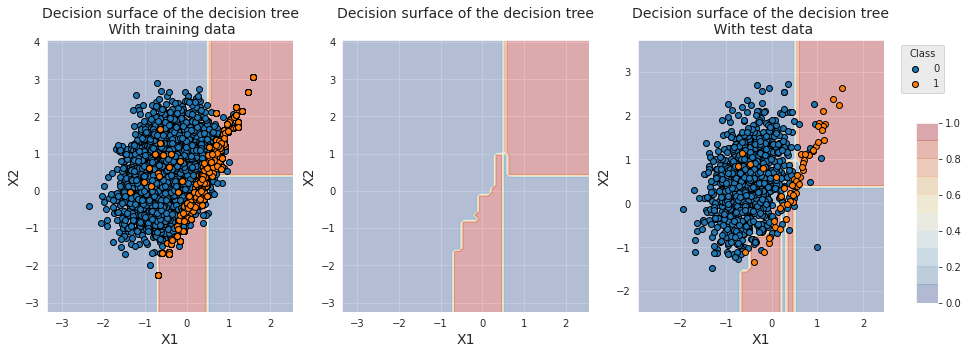

In [15]:
fig_decision_boundary

The classification performances show an increase in terms of balanced accuracy. We however note a decrease in terms of AUC ROC and Average Precision, due to the shift of the decision boundary which significantly increased the number of false positives. 

In [16]:
pd.concat([results_df_dt_baseline, 
           results_df_ROS])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.004+/-0.001,0.001+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - ROS,0.006+/-0.0,0.001+/-0.001,0.88+/-0.038,0.456+/-0.062,0.888+/-0.03


#### SMOTE

SMOTE {cite}`chawla2002smote` oversamples the minority class by generating synthetic examples in the neighborhood of observed ones. The idea is to form new minority examples by interpolating between samples of the same class. This has the effect of creating clusters around each minority observation. By creating synthetic observations, the classifier builds larger decision regions that contain nearby instances from the minority class. SMOTE has been shown to improve the performances of a base classifier in many applications {cite}`dal2015adaptive,chawla2002smote`

The `imblearn` sampler for SMOTE is [`imblearn.over_sampling.SMOTE`](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html). Let us illustrate the use of SMOTE, and its impact on the classifier decision boundary and the classification performances.

The implementation follows the same structure as the random oversampling. The only difference is to change the sampler to SMOTE.


In [17]:
%%capture

sampler_list = [('sampler', imblearn.over_sampling.SMOTE(sampling_strategy=1, random_state=0))]
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=0)

(results_df_SMOTE, classifier_0, train_df, test_df) = kfold_cv_with_sampler_and_classifier(classifier, 
                                                                                           sampler_list, 
                                                                                           X, y, 
                                                                                           n_splits=5,
                                                                                           strategy_name="Decision tree - SMOTE")


fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

As with random oversampling, the number of samples in the minority class is increased to match the number of samples in the majority class (`sampling_strategy=1`).

In [18]:
train_df['Y'].value_counts()

0    3784
1    3784
Name: Y, dtype: int64

The decision boundary is also shifted towards the minority class. We note that, contrary to random oversampling, new examples have been generated for the minority class.

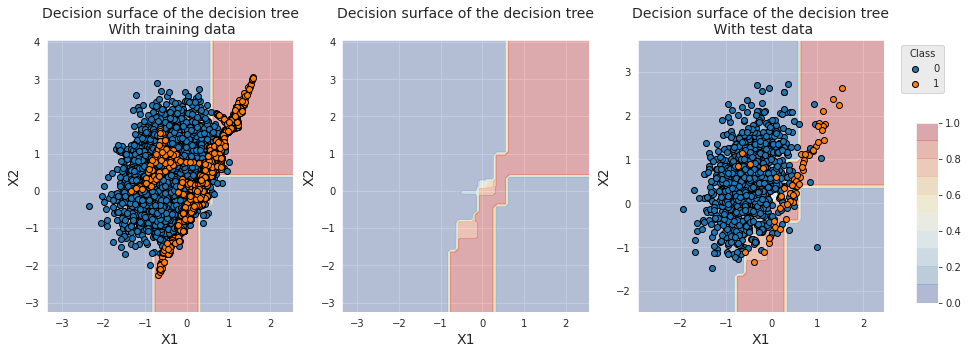

In [19]:
fig_decision_boundary

SMOTE provides higher performances than random oversampling for the three metrics. The Average Precision however remains lower than the baseline classifier.

In [20]:
pd.concat([results_df_dt_baseline, 
           results_df_ROS,
           results_df_SMOTE])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.004+/-0.001,0.001+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - ROS,0.006+/-0.0,0.001+/-0.001,0.88+/-0.038,0.456+/-0.062,0.888+/-0.03
Decision tree - SMOTE,0.007+/-0.001,0.001+/-0.0,0.913+/-0.032,0.499+/-0.056,0.91+/-0.019


#### Other oversampling strategies

There exists a range of more sophisticated strategies for oversampling, whose details go beyond the scope of this book. We refer the reader to {cite}`fernandez2018learning` for a review and to the [`imblearn` page on oversampling methods](https://imbalanced-learn.org/stable/references/over_sampling.html) for their implementations in Python. In particular the `imblearn` library provides the following additional oversampling methods: `SMOTENC` {cite}`chawla2002smote`, `SMOTEN` {cite}`chawla2002smote`, `ADASYN` {cite}`he2008adasyn`, `BorderlineSMOTE` {cite}`han2005borderline`, `KMeansSMOTE` {cite}`last2017oversampling`, and `SVMSMOTE` {cite}`nguyen2011borderline`. These methods can be used by simply replacing the sampler with the desired method in the code above. 



### Undersampling

Undersampling refers to the process of reducing the number of samples in the majority class. The naive approach, called *random undersampling* (RUS), consists in randomly removing samples from the majority class until the desired imbalance ratio is achieved. 

The major drawback of RUS is that the method may discard samples that are important for identifying the decision boundary. A range of more advanced techniques have been proposed that aim at removing samples in a more principled way {cite}`fernandez2018learning`. Besides RUS, the `imblearn` package proposes no less than ten different methods for undersampling {cite}`Imblearn`. Most of these methods rely on nearest neighbors heuristics that remove samples when they either lie close or far away from other samples. We refer the reader to {cite}`fernandez2018learning,Imblearn` for the detailed algorithms underlying more advanced undersampling methods.

The next two subsections show how two of these methods can be implemented, and illustrate their ability to move the decision boundary towards the minority class. As examples, we rely on RUS, and Edited Nearest Neighbor (ENN).


#### Random undersampling

The `imblearn` sampler for RUS is [`imblearn.under_sampling.RandomUnderSampler`](https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.RandomUnderSampler.html). Let us illustrate its use and its impact on the classifier decision boundary and the classification performances.

In [21]:
%%capture

sampler_list = [('sampler', imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state=0))]

classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=0)

(results_df_RUS, classifier_0, train_df, test_df) = kfold_cv_with_sampler_and_classifier(classifier, 
                                                                                         sampler_list, 
                                                                                         X, y, 
                                                                                         n_splits=5,
                                                                                         strategy_name="Decision tree - RUS")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

With a `sampling_strategy` set to one, RUS randomly removes samples from the majority class until their number reaches that of the minority class. After resampling, each class contains 216 samples.

In [22]:
train_df['Y'].value_counts()

0    216
1    216
Name: Y, dtype: int64

The plotting of training samples shows that the number of samples from the majority class was significantly reduced, allowing a shift of the decision boundary towards the minority class. Contrary to oversampling techniques, the region located at the bottom right is now associated with the minority class, since all samples of class 0 from this region have been removed.  

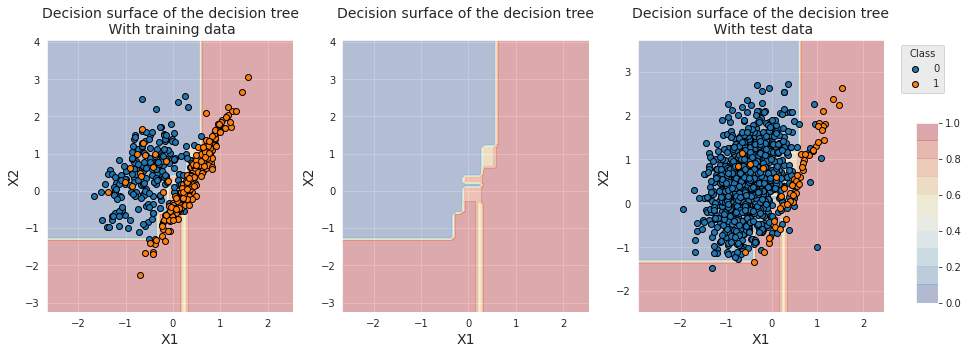

In [23]:
fig_decision_boundary

The performances in terms of AUC ROC and balanced accuracy are on par with oversampling techniques. We however note a loss of performance in terms of Average Precision. 

In [24]:
pd.concat([results_df_dt_baseline, 
           results_df_ROS,
           results_df_SMOTE,
           results_df_RUS])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.004+/-0.001,0.001+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - ROS,0.006+/-0.0,0.001+/-0.001,0.88+/-0.038,0.456+/-0.062,0.888+/-0.03
Decision tree - SMOTE,0.007+/-0.001,0.001+/-0.0,0.913+/-0.032,0.499+/-0.056,0.91+/-0.019
Decision tree - RUS,0.001+/-0.0,0.001+/-0.0,0.913+/-0.02,0.408+/-0.058,0.896+/-0.023


It is worth noting that the training time with RUS is faster. This results from the simple undersampling procedure and the smaller training set size. The method is therefore useful not only for reducing the imbalance ratio but also for speeding up the execution time of the modeling procedure.   

#### Edited Nearest Neighbor 

The Edited Nearest Neighbor rule is an undersampling technique that removes samples from the majority class in overlapping regions of the dataset {cite}`laurikkala2001improving,wilson1972asymptotic`. It is based on a nearest neighbor rule, that removes majority class samples as follows {cite}`fernandez2018learning` (Chapter 5, Page 84):

* For each majority class sample, the k-nearest neighbors are found. If the majority of these samples are from the minority class, the majority class sample is removed.
* For each minority class sample, the k-nearest neighbors are found. If the majority of these samples are from the majority class, the majority class sample(s) is (are) removed.

The number of neighbors $k$ is by default set to $k=3$. It is worth noting that, contrary to RUS, the number of majority class samples that are removed depends on the degree of overlap between the two classes. The method does not allow to specify an imbalanced ratio. 

The `imblearn` sampler for RUS is [`imblearn.under_sampling.EditedNearestNeighbours`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html). Let us illustrate its use and its impact on the classifier decision boundary and the classification performances. 


In [25]:
%%capture

sampler_list = [('sampler', imblearn.under_sampling.EditedNearestNeighbours(sampling_strategy='majority',n_neighbors=3))]

classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=0)

(results_df_ENN, classifier_0, train_df, test_df) = kfold_cv_with_sampler_and_classifier(classifier, 
                                                                                         sampler_list, 
                                                                                         X, y, 
                                                                                         n_splits=5,
                                                                                         strategy_name="Decision tree - ENN")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

With a number of neighbors `n_neighbors` set to three, ENN only removes around 200 samples out of the 3784 samples of the majority class. The number of samples from the minority class is unchanged. 

In [26]:
train_df['Y'].value_counts()

0    3572
1     216
Name: Y, dtype: int64

The plotting of training samples shows that the distributions of the two classes are similar to the original distributions. The samples that were removed lied in the overlapping region, and their removal is therefore not visible due to the large amount of remaining samples. We however observe a shift in the decicision boundary, since the decision tree now classifies samples from the overlapping region into the minority class. 

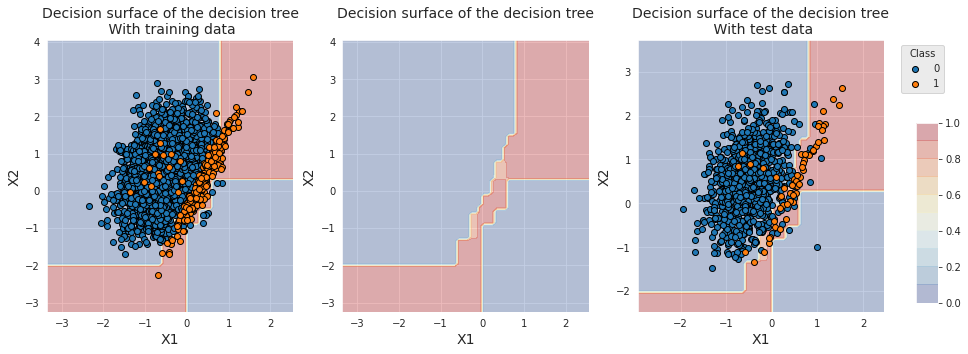

In [27]:
fig_decision_boundary

On this dataset, the performances of ENN are poor compared to the previsouly tested techniques. The balanced accuracy was slightly improved compared to the baseline classifier. The performance in terms of AP is however lower than the baseline, and the AUC ROC is the worst of all tested tecniques (and on par with ROS). 

In [28]:
pd.concat([results_df_dt_baseline, 
           results_df_ROS,
           results_df_SMOTE,
           results_df_RUS,
           results_df_ENN])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.004+/-0.001,0.001+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - ROS,0.006+/-0.0,0.001+/-0.001,0.88+/-0.038,0.456+/-0.062,0.888+/-0.03
Decision tree - SMOTE,0.007+/-0.001,0.001+/-0.0,0.913+/-0.032,0.499+/-0.056,0.91+/-0.019
Decision tree - RUS,0.001+/-0.0,0.001+/-0.0,0.913+/-0.02,0.408+/-0.058,0.896+/-0.023
Decision tree - ENN,0.008+/-0.0,0.001+/-0.0,0.879+/-0.038,0.474+/-0.08,0.857+/-0.041


#### Other undersampling strategies

As for ovesampling techniques, we refer the reader to {cite}`fernandez2018learning` for a review of more sophisticated undersampling techniques and to the [`imblearn` page on undersampling methods](https://imbalanced-learn.org/stable/references/under_sampling.html) for their implementations in Python. In particular the `imblearn` library provides ten other undersampling methods, which can be tested by simply replacing the sampler with the desired method in the code above. 


### Combining over and undersampling

Oversampling and undersampling are often complementary. On the one hand, oversampling techniques allow to generate synthetic samples from the minority class, and help a classifier in identifying more precisely the decision boundary between the two classes. On the other hand, undersampling techniques reduce the size of the training set, and allow to speed-up the classifier training time.  Combining over and undersampling techniques has often been reported to successfully improve the classifier performances (Chapter 5, Section 6 in {cite}fernandez2018learning).

In terms of implementation, the combination of samplers is obtained by chaining the samplers in a `pipeline`. The samplers can then be chained to a classifer. We illustrate below the chaining of an SMOTE oversampling to a random undersampling to a decision tree classifier. 

```
sampler_list = [('sampler1', imblearn.over_sampling.SMOTE(sampling_strategy=0.5,random_state=0)),
                ('sampler2', imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1.0,random_state=0))
               ]

classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=0)

estimators = sampler_list.extend([('clf', classifier)])
    
pipe = imblearn.pipeline.Pipeline(estimators)
```

The `kfold_cv_with_sampler_and_classifier` takes the `sampler_list` and the `classifier` as two separate arguments, and takes care of chaining the samplers and classifier together. We can therefore follow the same template as before for assessing the performances of a classifier based on a chain of resampling techniques. The samplers are provided as a list with the `sampler_list` variable.  

In [29]:
%%capture
sampler_list = [('sampler1', imblearn.over_sampling.SMOTE(sampling_strategy=0.5,random_state=0)),
                ('sampler2', imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1.0,random_state=0))
               ]

classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=0)

(results_df_combined, classifier_0, train_df, test_df) = kfold_cv_with_sampler_and_classifier(classifier, 
                                                                                              sampler_list, 
                                                                                              X, y, 
                                                                                              n_splits=5,
                                                                                              strategy_name='Decision tree - Combined SMOTE and RUS')

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

The SMOTE oversampling aimed at an imbalance ratio of 0.5. Since the original dataset contains 3784 sample of the majority class, SMOTE create new samples until the number of minority class samples reached $3784/2=1892$ samples. The random undersampling aimed at an imbalance ratio of 1. Since the SMOTE resampled dataset contains 1892 samples of the minority class, samples of the majority class are removed until their number reached 1892 samples. 

In [30]:
train_df['Y'].value_counts()

0    1892
1    1892
Name: Y, dtype: int64

The resulting decision boundary is close to that obtained with SMOTE, except that a slightly larger region is now considered to be of class 1 by the classifier. This is coherent since less samples of the minority class were created. 

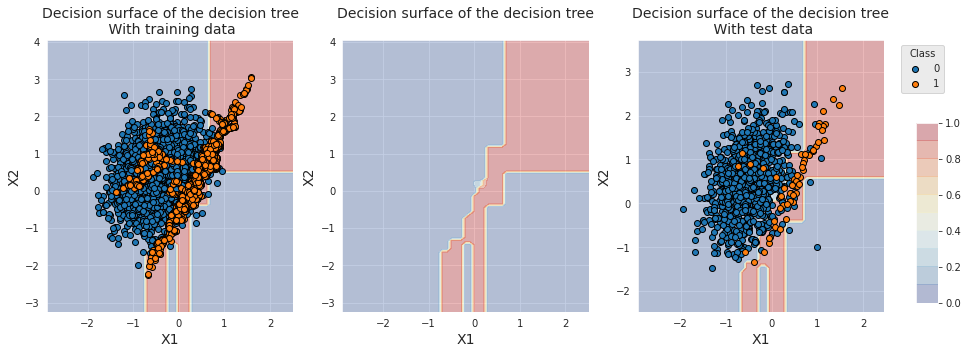

In [31]:
fig_decision_boundary

The resulting performances are on par with those of SMOTE. For larger dataset, one should however expect faster training times than SMOTE, since the training set size is decreased thanks to undersampling. 

In [32]:
pd.concat([results_df_dt_baseline, 
           results_df_ROS,
           results_df_SMOTE,
           results_df_RUS,
           results_df_ENN,
           results_df_combined])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.004+/-0.001,0.001+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - ROS,0.006+/-0.0,0.001+/-0.001,0.88+/-0.038,0.456+/-0.062,0.888+/-0.03
Decision tree - SMOTE,0.007+/-0.001,0.001+/-0.0,0.913+/-0.032,0.499+/-0.056,0.91+/-0.019
Decision tree - RUS,0.001+/-0.0,0.001+/-0.0,0.913+/-0.02,0.408+/-0.058,0.896+/-0.023
Decision tree - ENN,0.008+/-0.0,0.001+/-0.0,0.879+/-0.038,0.474+/-0.08,0.857+/-0.041
Decision tree - Combined SMOTE and RUS,0.006+/-0.0,0.002+/-0.001,0.915+/-0.012,0.494+/-0.062,0.912+/-0.005


## Transaction data

Let us now apply resampling techniques to the simulated dataset of transaction data. We reuse the methodology of [Chapter 5, Model Selection](Model_Selection), using prequential validation as the validation strategy.

### Load data

The loading of data and initialization of the parameters follow the same template as in [Chapter 5, Model Selection](Model_Selection).

In [33]:
# Load data from the 2018-07-11 to the 2018-09-14

DIR_INPUT = 'simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


# Number of folds for the prequential validation
n_folds = 4

# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }


Load  files
CPU times: user 156 ms, sys: 171 ms, total: 327 ms
Wall time: 328 ms
919767 transactions loaded, containing 8195 fraudulent transactions


As a baseline, let us compute the fraud detection performances with a decision tree of depth 5 without any resampling. 

In [34]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[5], 'clf__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_dt = time.time()-start_time

# Select parameter of interest (max_depth)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_dt=performances_df


In [35]:
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,5,5,5
Validation performance,0.804+/-0.02,0.546+/-0.04,0.268+/-0.01
Test performance,0.81+/-0.01,0.6+/-0.02,0.284+/-0.0
Optimal parameter(s),5,5,5
Optimal test performance,0.81+/-0.01,0.6+/-0.02,0.284+/-0.0


This baseline will be used at the end of the notebook to assess the benefits of different resampling techniques.  

### Prequential validation with resampling

The addition of resampling to the prequential validation simply consists in extending the pipeline defined in [Chapter 5, Validation Strategies](Sklearn_Validation_Pipeline) with the sampler objects. We add this step at the beginning of the `prequential_grid_search` function and rename it as `prequential_grid_search_with_sampler`. Note that the pipeline is created with the `Pipeline` object from the `imblearn` module so that samplers are properly processed.

In [36]:
def prequential_grid_search_with_sampler(transactions_df, 
                                         classifier, sampler_list,
                                         input_features, output_feature, 
                                         parameters, scoring, 
                                         start_date_training, 
                                         n_folds=4,
                                         expe_type='Test',
                                         delta_train=7, 
                                         delta_delay=7, 
                                         delta_assessment=7,
                                         performance_metrics_list_grid=['roc_auc'],
                                         performance_metrics_list=['AUC ROC'],
                                         n_jobs=-1):
    
    estimators = sampler_list.copy()
    estimators.extend([('clf', classifier)])
    
    pipe = imblearn.pipeline.Pipeline(estimators)
    
    prequential_split_indices = prequentialSplit(transactions_df,
                                                 start_date_training=start_date_training, 
                                                 n_folds=n_folds, 
                                                 delta_train=delta_train, 
                                                 delta_delay=delta_delay, 
                                                 delta_assessment=delta_assessment)
    
    grid_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, refit=False, n_jobs=n_jobs)
    
    X = transactions_df[input_features]
    y = transactions_df[output_feature]

    grid_search.fit(X, y)
    
    performances_df = pd.DataFrame()
    
    for i in range(len(performance_metrics_list_grid)):
        performances_df[performance_metrics_list[i]+' '+expe_type]=grid_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
        performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=grid_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

    performances_df['Parameters'] = grid_search.cv_results_['params']
    performances_df['Execution time'] = grid_search.cv_results_['mean_fit_time']
    
    return performances_df

The `model_selection_wrapper` function is also modified into a `model_selection_wrapper_with_sampler` function, which calls the `prequential_grid_search_with_sampler` function for prequential grid search. 

In [37]:
def model_selection_wrapper_with_sampler(transactions_df, 
                                         classifier, 
                                         sampler_list,
                                         input_features, output_feature,
                                         parameters, 
                                         scoring, 
                                         start_date_training_for_valid,
                                         start_date_training_for_test,
                                         n_folds=4,
                                         delta_train=7, 
                                         delta_delay=7, 
                                         delta_assessment=7,
                                         performance_metrics_list_grid=['roc_auc'],
                                         performance_metrics_list=['AUC ROC'],
                                         n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation = prequential_grid_search_with_sampler(transactions_df, classifier, sampler_list,
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Get performances on the test set using prequential validation
    performances_df_test = prequential_grid_search_with_sampler(transactions_df, classifier, sampler_list,
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Bind the two resulting DataFrames
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df = pd.concat([performances_df_test,performances_df_validation],axis=1)

    # And return as a single DataFrame
    return performances_df

Model selection with resampling can now be performed by calling the `model_selection_wrapper_with_sampler` function, following the same methodology as in [Chapter 5](Model_Selection). 

### Oversampling

Let us illustrate its use with SMOTE oversampling. We create a `SMOTE` object and store it in a `sampler_list` list. The list is passed as an argument to the `model_selection_wrapper_with_sampler` function. Additionally, the `sampling_strategy` parameter to the `SMOTE` object (imbalance ratio) is parametrized to take values in the set $[0.01, 0.05, 0.1, 0.5, 1]$ for the model selection procedure.  


In [38]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Define sampling strategy
sampler_list = [('sampler', imblearn.over_sampling.SMOTE(random_state=0))]

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[5], 'clf__random_state':[0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_SMOTE = time.time()-start_time


We then retrieve the performances for each of the tested imbalance ratios (`sampling_strategy` value) and store the results in a `performances_df_SMOTE` DataFrame.

In [39]:
# Select parameter of interest (sampling_strategy)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['sampler__sampling_strategy'] for i in range(len(parameters_dict))]

# Rename to performances_df_SMOTE for model performance comparison at the end of this notebook
performances_df_SMOTE = performances_df

In [40]:
performances_df_SMOTE

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.805165,0.005955,0.587136,0.010773,0.282143,0.007389,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.329580,0.803468,0.014269,0.554155,0.032957,0.267500,0.014120,0.01
1,0.823732,0.006235,0.572835,0.024824,0.285357,0.012753,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.347368,0.809590,0.018765,0.558479,0.027820,0.271429,0.010785,0.05
2,0.827219,0.010190,0.544275,0.037686,0.290357,0.010070,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.300897,0.807543,0.016324,0.537672,0.040918,0.268214,0.013224,0.10
3,0.842985,0.018418,0.558118,0.033607,0.289286,0.015860,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.411535,0.849501,0.015830,0.495635,0.052593,0.279286,0.018028,0.50
4,0.845270,0.008136,0.545954,0.031952,0.294643,0.011401,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.672336,0.857367,0.012183,0.493752,0.049094,0.278571,0.014463,1.00


Let us summarize the performances to highlight the optimal imbalance ratios.

In [41]:
summary_performances_SMOTE = get_summary_performances(performances_df_SMOTE, parameter_column_name="Parameters summary")
summary_performances_SMOTE

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,1.0,0.05,0.5
Validation performance,0.857+/-0.01,0.558+/-0.03,0.279+/-0.02
Test performance,0.845+/-0.01,0.573+/-0.02,0.289+/-0.02
Optimal parameter(s),1.0,0.01,1.0
Optimal test performance,0.845+/-0.01,0.587+/-0.01,0.295+/-0.01


We note conflicting results, as the optimal imbalance ratio depends on the performance metric. For better visualization, let us plot the performances as a function of the imbalance ratio for the three performance metrics.

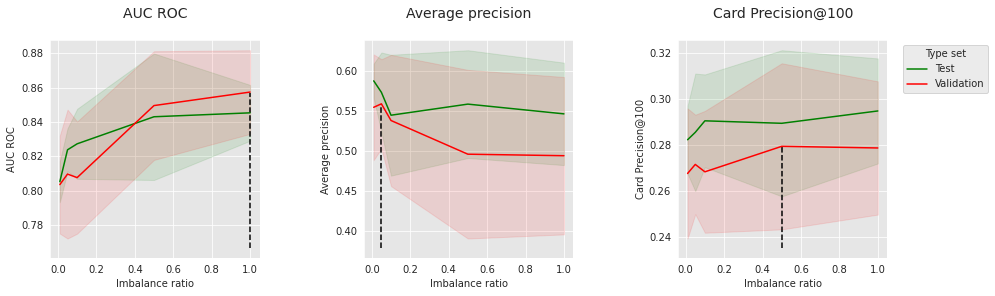

In [42]:
get_performances_plots(performances_df_SMOTE, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_SMOTE)

The performances tend to increase with the imbalance ratio for AUC ROC and CP@100. The opposite is however observed for Average Precision. The creation of synthetic samples with SMOTE is therefore beneficial to AUC ROC and CP@100, but detrimental to the Average Precision.  

### Undersampling

Let us follow the same methodology using random undersampling. The `RandomUnderSampler` object is used, and models are assessed for imbalance ratios taking values in the set $[0.01, 0.05, 0.1, 0.5, 1]$.

In [43]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Define sampling strategy
sampler_list = [('sampler', imblearn.under_sampling.RandomUnderSampler())]

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[5], 'clf__random_state':[0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_RUS = time.time()-start_time

# Select parameter of interest (sampling_strategy)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['sampler__sampling_strategy'] for i in range(len(parameters_dict))]

# Rename to performances_df_RUS for model performance comparison at the end of this notebook
performances_df_RUS = performances_df


Let us summarize the performances to highlight the optimal imbalance ratios, and plot the performances as a function of the imbalance ratio. 

In [44]:
summary_performances_RUS=get_summary_performances(performances_df_RUS, parameter_column_name="Parameters summary")
summary_performances_RUS

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,1.0,0.01,0.1
Validation performance,0.845+/-0.01,0.535+/-0.04,0.269+/-0.01
Test performance,0.83+/-0.01,0.594+/-0.02,0.277+/-0.01
Optimal parameter(s),1.0,0.01,0.5
Optimal test performance,0.83+/-0.01,0.594+/-0.02,0.292+/-0.01


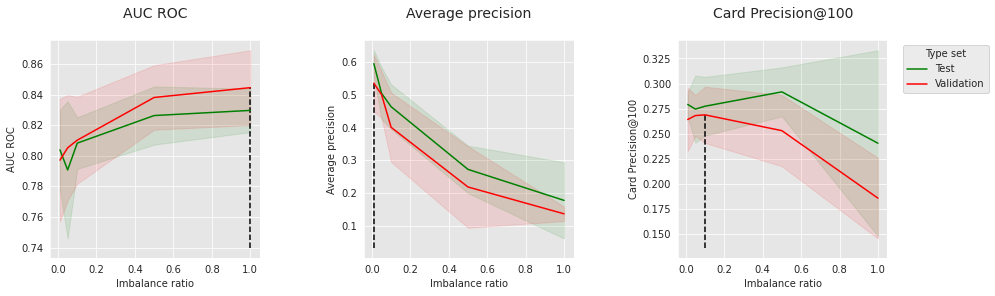

In [45]:
get_performances_plots(performances_df_RUS, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_RUS)

As with oversampling, rebalancing the dataset leads to an increase in performance in terms of AUC ROC, but to a strong decrease of performance in terms of AP. The results in terms of CP@100 follow an intermediate trend: The performance first slightly increases with the imbalance ratio, and then decreases with more aggressive undersampling.  

### Combining
We finally illustrate the combination of oversampling and undersampling with SMOTE and random undersampling. A `SMOTE` and `RandomUnderSampler` objects are instantiated and stored in the `sampler_list` list. We parametrize the `SMOTE` sampler with a target imbalance ratio of $0.1$, and the `RandomUnderSampler` to take values in the set $[0.1, 0.5, 1]$.

In [46]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Define sampling strategy
sampler_list = [('sampler1', imblearn.over_sampling.SMOTE()),
                ('sampler2', imblearn.under_sampling.RandomUnderSampler())
               ]

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[5], 'clf__random_state':[0],
              'sampler1__sampling_strategy':[0.1], 
              'sampler2__sampling_strategy':[0.1, 0.5, 1], 
              'sampler1__random_state':[0], 'sampler2__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df = model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_combined = time.time()-start_time

# Select parameter of interest (max_depth)
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['sampler2__sampling_strategy'] for i in range(len(parameters_dict))]

# Rename to performances_df_combined for model performance comparison at the end of this notebook
performances_df_combined = performances_df


In [47]:
performances_df_combined

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.827219,0.010190,0.544275,0.037686,0.290357,0.010070,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.297100,0.807543,0.016324,0.537672,0.040918,0.268214,0.013224,0.1
1,0.848464,0.008701,0.471467,0.010144,0.299643,0.011968,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.160151,0.841237,0.015297,0.428576,0.050091,0.279286,0.010903,0.5
2,0.847110,0.010754,0.385133,0.064916,0.287857,0.018364,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.147763,0.856399,0.012189,0.342964,0.020342,0.280357,0.017420,1.0


Let us summarize the performances to highlight the optimal imbalance ratios, and plot the performances as a function of the imbalance ratio. 

In [48]:
summary_performances_combined = get_summary_performances(performances_df=performances_df_combined, 
                                                         parameter_column_name="Parameters summary")
summary_performances_combined

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,1.0,0.1,1.0
Validation performance,0.856+/-0.01,0.538+/-0.04,0.28+/-0.02
Test performance,0.847+/-0.01,0.544+/-0.04,0.288+/-0.02
Optimal parameter(s),0.5,0.1,0.5
Optimal test performance,0.848+/-0.01,0.544+/-0.04,0.3+/-0.01


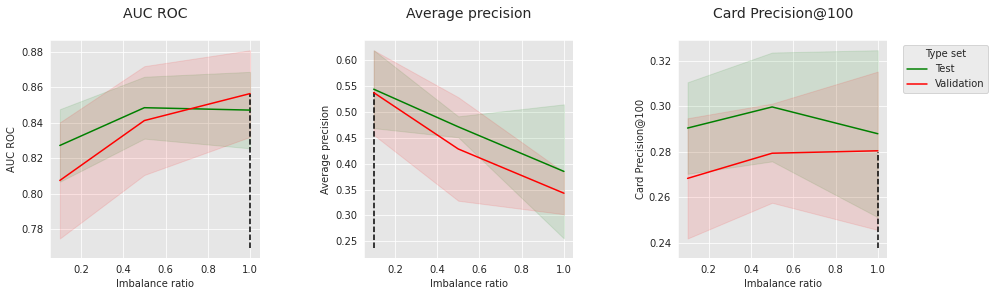

In [49]:
get_performances_plots(performances_df_combined, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_combined)

The results follow the same trends as with oversampling and undersampling: Rebalancing improves the performances in terms of AUC ROC, but decreases the performances in terms of Average Precision. The impact of rebalancing on CP@100 is mitigated.

Let us finally compare the test performances obtained with the oversampling, undersampling, and combined resampling, and compare them to the baseline classifier.  

In [50]:
summary_test_performances = pd.concat([summary_performances_dt.iloc[2,:],
                                       summary_performances_SMOTE.iloc[2,:],
                                       summary_performances_RUS.iloc[2,:],
                                       summary_performances_combined.iloc[2,:],
                                      ],axis=1)
summary_test_performances.columns=['Baseline', 'SMOTE', 'RUS', 'Combined']
summary_test_performances

,Baseline,SMOTE,RUS,Combined
AUC ROC,0.81+/-0.01,0.845+/-0.01,0.83+/-0.01,0.847+/-0.01
Average precision,0.6+/-0.02,0.573+/-0.02,0.594+/-0.02,0.544+/-0.04
Card Precision@100,0.284+/-0.0,0.289+/-0.02,0.277+/-0.01,0.288+/-0.02


Compared to the baseline classifier, all resampling techniques managed to improve the performances in terms of AUC ROC. All of them however led to a decrease in Average Precision. Slight improvements in terms of CP@100 could be achieved with SMOTE and the combined approach, but not with undersampling. 

## Summary

The experiments carried out in this section illustrated that the benefits of resampling techniques depend on the performance metric that is used. While resampling can generally be beneficial to AUC ROC, we observed that they led in almost all cases to a decrease of performances in terms of Average Precision. It is worth noting that the results are coherent with those obtained using cost-sensitive techniques in [the previous section](Cost_Sensitive_Learning). 

## Saving of results

Let us finally save the performance results and execution times.

In [51]:
performances_df_dictionary={
    "SMOTE": performances_df_SMOTE,
    "RUS": performances_df_RUS,
    "Combined": performances_df_combined
}

execution_times=[execution_time_dt_SMOTE,
                 execution_time_dt_RUS,
                 execution_time_dt_combined,
                ]


In [52]:
filehandler = open('performances_resampling.pkl', 'wb') 
pickle.dump((performances_df_dictionary, execution_times), filehandler)
filehandler.close()